In [16]:
# ------------------------------------------------------------
# CNN MODEL
# ------------------------------------------------------------

import os, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models, callbacks, optimizers

pd.options.display.max_columns = None

warnings.filterwarnings("ignore")

In [17]:
# ------------------------------------------------------------
# 1. DATA LOAD
# ------------------------------------------------------------

DATA_FILE = "fred_combined_2022-2023.xls"       # .csv works too

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"{DATA_FILE} not found in the current directory")
try:
    df = pd.read_csv(DATA_FILE)
except Exception:
    df = pd.read_excel(DATA_FILE, engine="openpyxl")

df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").set_index("DATE")

TARGET_COL = "SP500"                      # S&P500 Index

if TARGET_COL not in df.columns:
    raise ValueError(f"{TARGET_COL} column not found")

In [18]:
# ------------------------------------------------------------
# 2. WINDOW, SCALE, AND SPLIT
# ------------------------------------------------------------

N_STEPS = 10
feat_mat = df.values
n_feats  = feat_mat.shape[1]

scaler_x, scaler_y = StandardScaler(), StandardScaler()
X_all, y_all = [], []

for i in range(len(df) - N_STEPS):
    X_all.append(feat_mat[i:i + N_STEPS])
    y_all.append(feat_mat[i + N_STEPS, df.columns.get_loc(TARGET_COL)])

X_all = np.array(X_all)                        # (samples, steps, features)
y_all = np.array(y_all).reshape(-1, 1)

n_total = len(X_all)
n_train = int(n_total * 0.80)
n_val   = int(n_total * 0.10)

X_train, y_train = X_all[:n_train],                y_all[:n_train]
X_val,   y_val   = X_all[n_train:n_train+n_val],   y_all[n_train:n_train+n_val]
X_test,  y_test  = X_all[n_train+n_val:],          y_all[n_train+n_val:]

# Fit scalers on the training set only
scaler_x.fit(X_train.reshape(-1, n_feats))
scaler_y.fit(y_train)

def scale_X(arr):
    flat = arr.reshape(-1, n_feats)
    flat = scaler_x.transform(flat)
    return flat.reshape(arr.shape)

X_train = scale_X(X_train)
X_val   = scale_X(X_val)
X_test  = scale_X(X_test)

y_train = scaler_y.transform(y_train)
y_val   = scaler_y.transform(y_val)
y_test  = scaler_y.transform(y_test)

In [19]:
# ------------------------------------------------------------
# 3. CNN MODEL
# ------------------------------------------------------------

INPUT_SHAPE = (N_STEPS, n_feats)

def build_cnn():
    model = models.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        layers.Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1)                          # regression output
    ])
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mse"]
    )
    return model

model = build_cnn()
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/500
10/10 - 2s - 232ms/step - loss: 0.4745 - mse: 0.4745 - val_loss: 0.1909 - val_mse: 0.1909
Epoch 2/500
10/10 - 0s - 41ms/step - loss: 0.2093 - mse: 0.2093 - val_loss: 0.6298 - val_mse: 0.6298
Epoch 3/500
10/10 - 0s - 12ms/step - loss: 0.1509 - mse: 0.1509 - val_loss: 0.5491 - val_mse: 0.5491
Epoch 4/500
10/10 - 0s - 14ms/step - loss: 0.1327 - mse: 0.1327 - val_loss: 0.7719 - val_mse: 0.7719
Epoch 5/500
10/10 - 0s - 15ms/step - loss: 0.1268 - mse: 0.1268 - val_loss: 0.2379 - val_mse: 0.2379
Epoch 6/500
10/10 - 0s - 15ms/step - loss: 0.0918 - mse: 0.0918 - val_loss: 0.5063 - val_mse: 0.5063
Epoch 7/500
10/10 - 0s - 29ms/step - loss: 0.1065 - mse: 0.1065 - val_loss: 0.3800 - val_mse: 0.3800
Epoch 8/500
10/10 - 0s - 13ms/step - loss: 0.0859 - mse: 0.0859 - val_loss: 0.6143 - val_mse: 0.6143
Epoch 9/500
10/10 - 0s - 14ms/step - loss: 0.0951 - mse: 0.0951 - val_loss: 0.9581 - val_mse: 0.9581
Epoch 10/500
10/10 - 0s - 13ms/step - loss: 0.0825 - mse: 0.0825 - val_loss: 0.3277 - val_


Test RMSE: 152.1269 USD


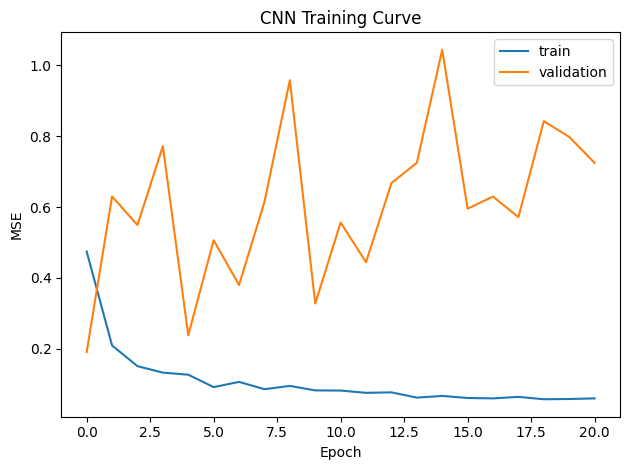

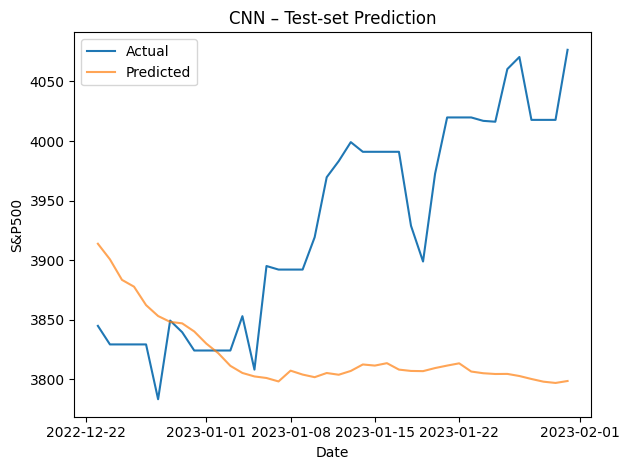

In [20]:
# ------------------------------------------------------------
# 4. EVALUATION AND VISUALIZATION
# ------------------------------------------------------------

def inverse_y(scaled):
    return scaler_y.inverse_transform(scaled.reshape(-1, 1)).flatten()

y_pred_scaled = model.predict(X_test, verbose=0).flatten()
y_pred = inverse_y(y_pred_scaled)
y_true = inverse_y(y_test.flatten())

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"\nTest RMSE: {rmse:,.4f} USD")

# Training/validation loss curve
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("CNN Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Actual vs. predicted on the test set
plt.figure()
plt.plot(df.index[-len(y_true):], y_true, label="Actual")
plt.plot(df.index[-len(y_true):], y_pred, label="Predicted", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("S&P500")
plt.title("CNN – Test-set Prediction")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE in %

print(f"\nTest RMSE: {rmse:,.4f}")
print(f"Test MAE : {mae:,.4f}")
print(f"Test MAPE: {mape:,.2f}%")


Test RMSE: 152.1269
Test MAE : 126.6611
Test MAPE: 3.18%


In [8]:
# ------------------------------------------------------------
# 5. SAVE MODEL
# ------------------------------------------------------------

model.save("cnn_snp500_model.h5")
print("Model saved as cnn_snp500_model.h5")

Model saved as cnn_snp500_model.h5


In [22]:
!pip install keras-tuner

import os, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

warnings.filterwarnings("ignore")

# ----------------------
# 6. HYPER-PARAMETER TUNING KERASTUNER
# ----------------------
DATA_FILE = "fred_combined_2022-2023.xls"       # .csv works too

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"{DATA_FILE} not found in the current directory")
try:
    df = pd.read_csv(DATA_FILE)
except Exception:
    df = pd.read_excel(DATA_FILE, engine="openpyxl")

df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").set_index("DATE")

TARGET_COL = "SP500"                      # S&P500 Index

if TARGET_COL not in df.columns:
    raise ValueError(f"{TARGET_COL} column not found")

feat_mat = df.values
n_feats = feat_mat.shape[1]
X_all, y_all = [], []

In [23]:
for i in range(len(df) - N_STEPS):
    X_all.append(feat_mat[i:i + N_STEPS])
    y_all.append(feat_mat[i + N_STEPS, df.columns.get_loc(TARGET_COL)])

X_all = np.array(X_all)
y_all = np.array(y_all).reshape(-1, 1)

# ----------------------
# Train/Val/Test Split (80/10/10)
# ----------------------
n_total = len(X_all)
n_train = int(n_total * 0.80)
n_val   = int(n_total * 0.10)

X_train, y_train = X_all[:n_train], y_all[:n_train]
X_val, y_val     = X_all[n_train:n_train + n_val], y_all[n_train:n_train + n_val]
X_test, y_test   = X_all[n_train + n_val:], y_all[n_train + n_val:]

# ----------------------
# Scaling
# ----------------------
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(X_train.reshape(-1, n_feats))
scaler_y.fit(y_train)

def scale_X(arr):
    flat = arr.reshape(-1, n_feats)
    flat = scaler_x.transform(flat)
    return flat.reshape(arr.shape)

X_train = scale_X(X_train)
X_val   = scale_X(X_val)
X_test  = scale_X(X_test)

y_train = scaler_y.transform(y_train)
y_val   = scaler_y.transform(y_val)
y_test  = scaler_y.transform(y_test)

In [24]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(N_STEPS, n_feats)))
    for i in range(hp.Int("conv_layers", 1, 3)):
        model.add(layers.Conv1D(
            filters=hp.Int(f"filters_{i}", 32, 128, step=32),
            kernel_size=3,
            padding="causal",
            activation="relu"
        ))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(hp.Int("dense_units", 32, 128, step=32), activation="relu"))
    model.add(layers.Dropout(hp.Float("dropout", 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=optimizers.Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=["mse"]
    )
    return model

In [25]:
# ----------------------
# Keras Tuner Search
# ----------------------
tuner = RandomSearch(
    build_model,
    objective="val_mse",
    max_trials=20,
    executions_per_trial=1,
    directory="cnn_tuning",
    project_name="sp500"
)

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=32,
             callbacks=[early_stop],
             verbose=2)

# ----------------------
# Evaluate Best Model
# ----------------------
best_model = tuner.get_best_models(1)[0]

def inverse_y(scaled):
    return scaler_y.inverse_transform(scaled.reshape(-1, 1)).flatten()

y_pred_scaled = best_model.predict(X_test).flatten()
y_pred = inverse_y(y_pred_scaled)
y_true = inverse_y(y_test.flatten())

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\nTest RMSE: {rmse:,.4f}")
print(f"Test MAE : {mae:,.4f}")
print(f"Test MAPE: {mape:,.2f}%")

Trial 20 Complete [00h 00m 05s]
val_mse: 0.05467739701271057

Best val_mse So Far: 0.0357205793261528
Total elapsed time: 00h 07m 19s
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Test RMSE: 59.5001
Test MAE : 53.3401
Test MAPE: 1.36%


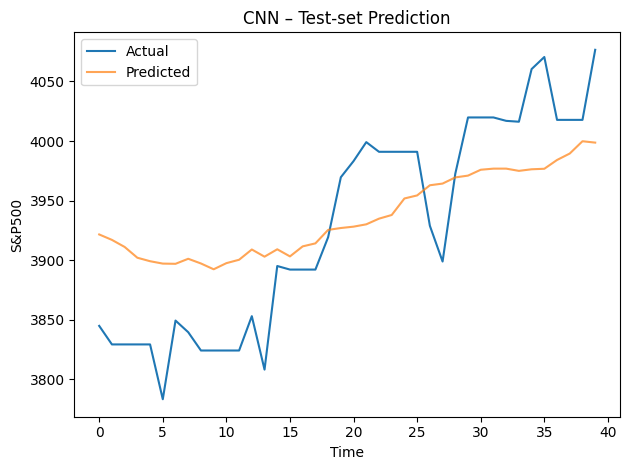

In [26]:
# ----------------------
# Plot Results
# ----------------------
plt.figure()
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("S&P500")
plt.title("CNN – Test-set Prediction")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# ------------------------------------------------------------
# SAVE MODEL
# ------------------------------------------------------------

model.save("cnn_snp500_optimized_model.h5")
print("Model saved as cnn_snp500_model.h5")

Model saved as cnn_snp500_model.h5
